# BNN visualization

In [1]:
import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt


from src.data.data_loader import load_mauna_loa_atmospheric_co2, load_international_airline_passengers
from sklearn.model_selection import train_test_split

from src.models.BnnModel import BayesianModel
from src.models.train_bnn import train_bnn_model

MUANA_DATA_PATH = "../data/mauna_loa_atmospheric_co2.csv"
AIRLINE_DATA_PATH = "../data/international-airline-passengers.csv"

 <h2>mauna_loa_atmospheric_co2 Dataset

<h3> Traning

In [2]:
# Prepare data
X1, y1, X1_normalized = load_mauna_loa_atmospheric_co2(MUANA_DATA_PATH)

# Split the data into training and test sets
X1_train, X1_test, y1_train, y1_test = train_test_split(
    X1_normalized, y1, test_size=0.2, random_state=42
)

# Convert NumPy arrays to PyTorch tensors
X1_train_tensor = torch.from_numpy(X1_train).float()
y1_train_tensor = torch.from_numpy(y1_train).float()
X1_test_tensor = torch.from_numpy(X1_test).float()

# Define the Bayesian neural network model
input_size = X1_train.shape[1]
HIDDEN_SIZE1 = 20
HIDDEN_SIZE2 = 40
OUTPUT_SIZE = 1
model_mauna = BayesianModel(input_size, HIDDEN_SIZE1, HIDDEN_SIZE2, OUTPUT_SIZE)


# Training loop
epochs = 1000
train_losses_mauna = train_bnn_model(model_mauna, X1_train_tensor, y1_train_tensor)

# export the model
torch.save(model_mauna, "../models/bnn_mauna.pth")

Training:   0%|          | 4/1000 [00:00<01:08, 14.55epoch/s, Loss=1.24e+4]

Training: 100%|██████████| 1000/1000 [01:03<00:00, 15.76epoch/s, Loss=5.07] 


<h3> Training Loss Over Epochs

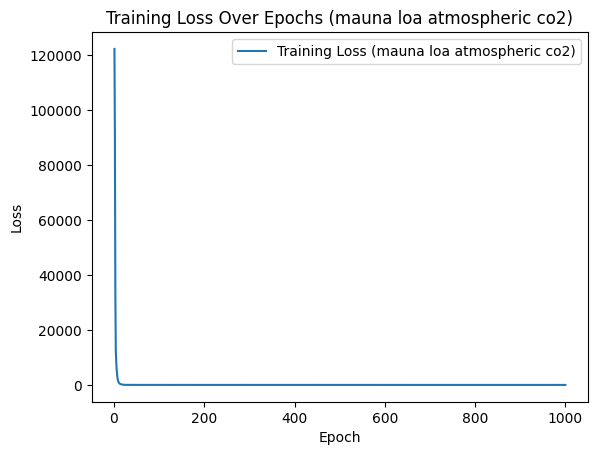

<Figure size 640x480 with 0 Axes>

In [3]:
# Plot training losses
plt.plot(range(1, epochs + 1), train_losses_mauna,
        label="Training Loss (mauna loa atmospheric co2)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs (mauna loa atmospheric co2)")
plt.legend()
plt.show()

# export the plot
plt.savefig("../models/mauna_loa_atmospheric_co2_training_loss.jpeg", bbox_inches = 'tight')


<h3>Ground Truth and Predictions

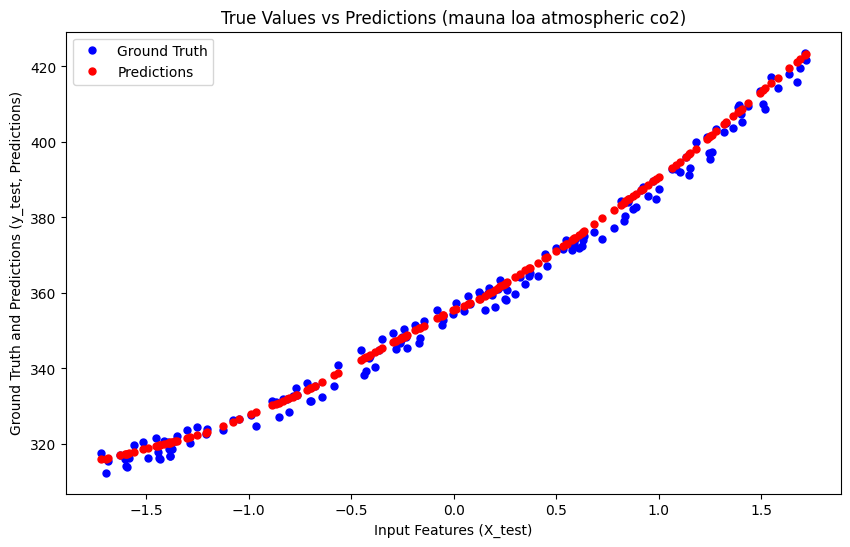

<Figure size 640x480 with 0 Axes>

In [4]:
# Evaluate the model on the test set
with torch.no_grad():
    model_mauna.eval()
    predictions_mauna = model_mauna(X1_test_tensor)

# Convert predictions to NumPy array for plotting
predictions_np_mauna = predictions_mauna.numpy()

# Plot Ground Truth vs Predictions
plt.figure(figsize=(10, 6))
plt.plot(X1_test, y1_test, "b.", markersize=10, label="Ground Truth")
plt.plot(X1_test, predictions_np_mauna, "r.", markersize=10, label="Predictions")
plt.xlabel("Input Features (X_test)")
plt.ylabel("Ground Truth and Predictions (y_test, Predictions)")
plt.title(f"True Values vs Predictions (mauna loa atmospheric co2)")
plt.legend()
plt.show()

# export the plot
plt.savefig("../models/mauna_loa_atmospheric_co2_predictions.png")

<h3>Uncertanty 

100%|██████████| 10/10 [00:00<00:00, 1345.67it/s]


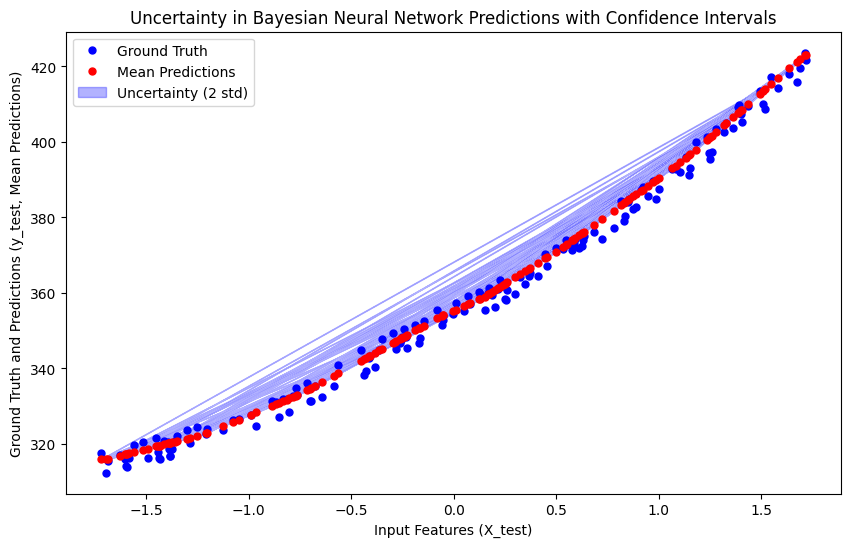

<Figure size 640x480 with 0 Axes>

In [5]:
def bnn_uncertainty_decomposition(model, X_test, num_samples=100):
    """
    Visualize the decomposition of uncertainty in a Bayesian neural network model.

    Parameters:
    - model (BayesianModel): Bayesian neural network model.
    - X_test (Tensor): Input features for testing.

    Returns:
    - mean_predictions (array-like): Mean predictions.
    - epestimic_uncertainty (array-like): Epistemic uncertainty.
    - aleatoric_uncertainty (array-like): Aleatoric uncertainty.
    """
    # Set the model to evaluation mode
    model.eval()

    # Draw samples from the posterior and make predictions
    predictions = np.zeros((num_samples, X_test.shape[0]))
    for i in tqdm(range(num_samples)):
        with torch.no_grad():
            predictions[i] = model(X_test).flatten().numpy()

    # Compute mean and standard deviation of predictions
    mean_predictions = predictions.mean(axis=0)
    std_predictions = predictions.std(axis=0)

    # Compute epistemic uncertainty
    epestimic_uncertainty = std_predictions ** 2

    # Compute aleatoric uncertainty
    aleatoric_uncertainty = np.zeros(X_test.shape[0])
    for i in range(X_test.shape[0]):
        aleatoric_uncertainty[i] = np.mean(
            (predictions[:, i] - mean_predictions[i]) ** 2
        )

    return mean_predictions, epestimic_uncertainty, aleatoric_uncertainty

mean_predictions, epestimic_uncertainty, aleatoric_uncertainty = bnn_uncertainty_decomposition(
    model_mauna, X1_test_tensor, 10
)

# plot uncertanty confidence interval and observations nd f function

def plot_bnn_uncertainty_confidence_interval(
    X_test, y_test, mean_predictions, epestimic_uncertainty
):
    """
    Plot the uncertainty of a Bayesian neural network model with confidence intervals.

    Parameters:
    - X_test (array-like): Input features for testing.
    - y_test (array-like): Ground truth values.
    - mean_predictions (array-like): Mean predictions.
    - std_predictions (array-like): Standard deviation of predictions.
    - num_samples (int): Number of samples to draw from the posterior.

    Returns:
    None
    """

    y_test = y_test.flatten()
    # Plot the ground truth and mean predictions
    plt.figure(figsize=(10, 6))
    plt.plot(X_test, y_test, "b.", markersize=10, label="Ground Truth")
    plt.plot(X_test, mean_predictions, "r.", markersize=10, label="Mean Predictions")
    plt.fill_between(
        X_test.flatten(),
        mean_predictions - epestimic_uncertainty,
        mean_predictions + epestimic_uncertainty,
        color="b",
        alpha=0.3,
        label="Uncertainty (2 std)",
    )
    plt.xlabel("Input Features (X_test)")
    plt.ylabel("Ground Truth and Predictions (y_test, Mean Predictions)")
    plt.title("Uncertainty in Bayesian Neural Network Predictions with Confidence Intervals")
    plt.legend()
    plt.show()
    
# Plot uncertainty with confidence intervals
plot_bnn_uncertainty_confidence_interval(X1_test_tensor, y1_test, mean_predictions, epestimic_uncertainty)

# export the plot
plt.savefig("../models/mauna_loa_atmospheric_co2_uncertainty.png")


<h2>International-airline-passengers dataset

<h3>Training

In [6]:
# Prepare data
X2, y2, X2_normalized = load_international_airline_passengers(AIRLINE_DATA_PATH)

# Split the data into training and test sets
X2_train, X2_test, y2_train, y2_test = train_test_split(
    X2_normalized, y2, test_size=0.2, random_state=42
)

# Convert NumPy arrays to PyTorch tensors
X2_train_tensor = torch.from_numpy(X2_train).float()
y2_train_tensor = torch.from_numpy(y2_train).float()
X2_test_tensor = torch.from_numpy(X2_test).float()

# Define the Bayesian neural network model
input_size = X2_train.shape[1]
HIDDEN_SIZE1 = 10
HIDDEN_SIZE2 = 40
OUTPUT_SIZE = 1
model_airline = BayesianModel(input_size, HIDDEN_SIZE1, HIDDEN_SIZE2, OUTPUT_SIZE)

# Training loop
train_losses_airline = train_bnn_model(model_airline, X2_train_tensor, y2_train_tensor)

# export the model
torch.save(model_airline, "../models/bnn_airline.pth")


Training:   3%|▎         | 26/1000 [00:00<00:15, 63.54epoch/s, Loss=3.58e+3]

Training: 100%|██████████| 1000/1000 [00:15<00:00, 63.56epoch/s, Loss=1.98e+3]


<H3>Training Loss Over Epochs

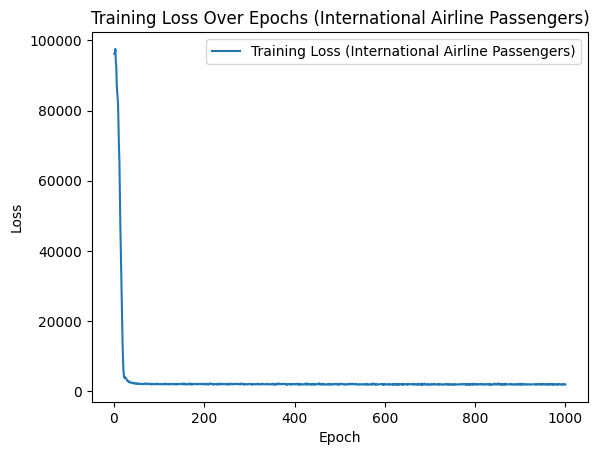

<Figure size 640x480 with 0 Axes>

In [7]:


# Plot training losses
plt.plot(range(1, epochs + 1), train_losses_airline,
        label="Training Loss (International Airline Passengers)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs (International Airline Passengers)")
plt.legend()
plt.show()

# export the plot
plt.savefig("../models/international_airline_passengers_training_loss.png")

<h3>Ground Truth and Predictions

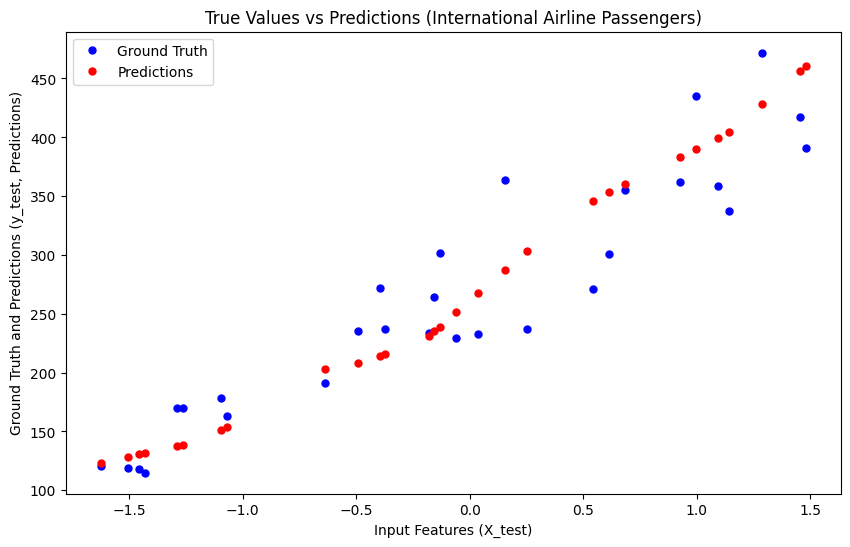

<Figure size 640x480 with 0 Axes>

In [8]:
# Evaluate the model on the test set
with torch.no_grad():
    model_airline.eval()
    predictions_airline = model_airline(X2_test_tensor)

# Convert predictions to NumPy array for plotting
predictions_np_airline = predictions_airline.numpy()

# Plot Ground Truth vs Predictions
plt.figure(figsize=(10, 6))
plt.plot(X2_test, y2_test, "b.", markersize=10, label="Ground Truth")
plt.plot(X2_test, predictions_np_airline, "r.", markersize=10, label="Predictions")
plt.xlabel("Input Features (X_test)")
plt.ylabel("Ground Truth and Predictions (y_test, Predictions)")
plt.title(f"True Values vs Predictions (International Airline Passengers)")
plt.legend()
plt.show()

# export the plot
plt.savefig("../models/international_airline_passengers_predictions.png")

100%|██████████| 100/100 [00:00<00:00, 1348.05it/s]


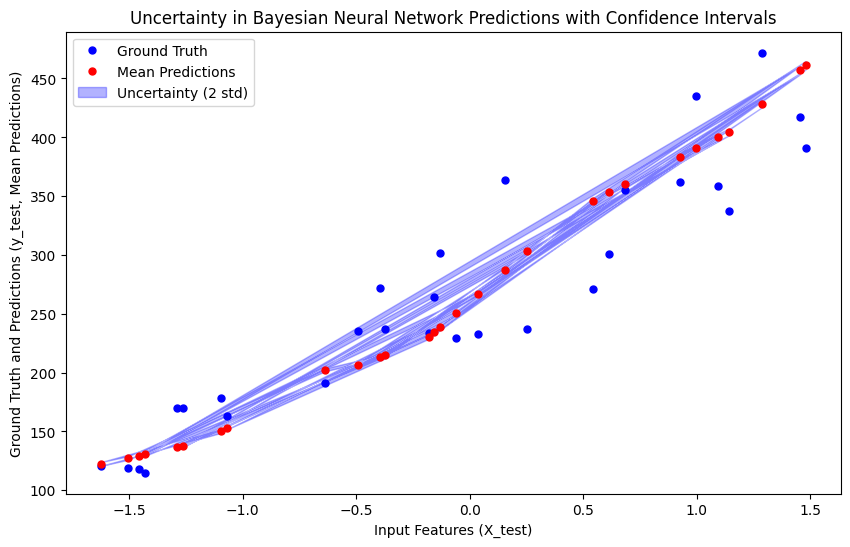

<Figure size 640x480 with 0 Axes>

In [9]:
mean_predictions, epestimic_uncertainty, aleatoric_uncertainty = bnn_uncertainty_decomposition(
    model_airline, X2_test_tensor, 100
)

# Plot uncertainty with confidence intervals
plot_bnn_uncertainty_confidence_interval(X2_test_tensor, y2_test, mean_predictions, epestimic_uncertainty)

# export the plot
plt.savefig("../models/international_airline_passengers_uncertainty.png")